# Imports

In [19]:
%reload_ext autoreload
%autoreload 2

from src.data.make_dataset import make_dataset
from src.data.make_labels import make_labels
from src.models.HTK import hmm

from src import features
from src import models

from src.visualization import visualize as viz

# Inicializo Verta

In [20]:
from verta import Client

HOST = "http://127.0.0.1:3000/"

PROJECT_NAME = "NPF Detector"
EXPERIMENT_NAME = "2_normalize"
EXPERIMENT_DESCRIPTION = "Data Version -> 2. Notebook -> 2-EventNoEvent_HInit_normalized.ipynb"


client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run(desc=EXPERIMENT_DESCRIPTION)

connection successfully established
set existing Project: NPF Detector from personal workspace
set existing Experiment: 2_normalize
created new ExperimentRun: Run 256851597957926874422


# Preparo los datos

In [21]:
data_version = 2
normalize = True

n_test, n_train = make_dataset(normalize, data_version)

run.log_observation('number_of_test_files', n_test)
run.log_observation('number_of_train_files', n_train)

run.log_hyperparameters({'data_version' : data_version, 'normalize': normalize})

INFO:root:Converting raw files to HTK format ...
INFO:root:Data version: 2
INFO:root:Generating script (.scp) files...
INFO:root:Adding deltas and acelerations...


# Pongo las etiquetas

In [22]:
thresholds = {'nuc_threshold': 0.15,        # 1/cm3/10min
              'pos_vol_threshold': 200,     # 1/m3^3/10min
              'neg_vol_threshold': -5000    # 1/cm3/10min
              }  

make_labels(thresholds, how='event-noevent', data_version=2)

run.log_hyperparameters(thresholds)

INFO:root:Creating labels ...
INFO:root:Labels created OK!
INFO:root:Generating Master Label File...


## Inicializo el modelo de Markov

Edito el el archivo hmmdefs y le agrego los modelos creados con HInit

In [23]:
init_func = 'HCompV'
vf = 0.1
mv = 0.1

model = hmm.initialize(how=init_func, variance_floor=vf, minimum_variance=mv)

run.log_hyperparameters({'initialization_function': init_func, 'var_floor': vf, 'var_min': mv})

INFO:root:Initializing model...


Calculating Fixed Variance
  HMM Prototype: ../src/models/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: ../models/hmm/0
219312 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory ../models/hmm/0
Var floor macros output to file ../models/hmm/0/vFloors



### Estimo los parametros y evaluo los resultados

In [24]:
model = hmm.train(model)

results = hmm.test(model)

for k,v in results.items():
    run.log_observation(k,v)

Pruning-Off

Pruning-Off

Pruning-Off

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/models/HTK/misc/config -H ../models/hmm/3/macros -H ../models/hmm/3/hmmdefs -p 0 -s 5 -A -w ../src/models/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results.mlf ../src/models/HTK/misc/dict ../src/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Aug 20 18:15:44 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results.mlf
------------------------ Overall Results --------------------------
SENT: %Correct=90.18 [H=147, S=16, N=163]
WORD: %Corr=83.67, Acc=83.67 [H=205, D=38, S=2, I=0, N=245]
------------------------ Confusion Matrix -------------------------
       e   n 
           e  Del [ %c / %e]
   e  44   0   16
  ne   2  161  22 [98.8/0.8]
Ins    0   0



### Agrego la transicion entre los estados 2 y 4 para el estado estaiconario

In [7]:
edit_commands = ['AT 2 4 0.2 {ne.TRANSP}', 
                 'AT 4 2 0.2 {ne.TRANSP}']

model = hmm.edit(model, edit_commands, reestimate=True)

results = hmm.test(model)

for k,v in results.items():
    run.log_observation(k,v)

for command in edit_commands:    
    run.log_observation('model_edit_commands', command)

# Aumento el numero de Gausianas

In [8]:
edit_commands = ['MU 2 {*.state[2-4].mix}', 'MU 4 {*.state[2-4].mix}', 'MU 8 {*.state[2-4].mix}']

model = hmm.edit(model, edit_commands, reestimate=True)
results = hmm.test(model)

for k,v in results.items():
    run.log_observation(k,v)

for command in edit_commands:    
    run.log_observation('model_edit_commands', command)

HHEd
 2/2 Models Loaded [5 states max, 1 mixes max]

MU 2 {}
 Mixup to 2 components per stream
 MU: Number of mixes increased from 6 to 12

MU 4 {}
 Mixup to 4 components per stream
 MU: Number of mixes increased from 12 to 24

MU 8 {}
 Mixup to 8 components per stream
 MU: Number of mixes increased from 24 to 48

Saving new HMM files ...
Edit Complete

Pruning-Off

Pruning-Off

Pruning-Off

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/models/HTK/misc/config -H ../models/hmm/7/macros -H ../models/hmm/7/hmmdefs -p 0 -s 5 -A -w ../src/models/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results.mlf ../src/models/HTK/misc/dict ../src/models/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Aug 20 17:37:47 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results.mlf
------------------------ Overall Results --------------------------
SENT: %Correct=94.01 [H=1

In [9]:
run.log_metric('Correct_labels', results['WORD_Corr'])
run.log_artifact('final_model', '../models/hmm/' + str(model), overwrite=True)

upload complete (final_model)


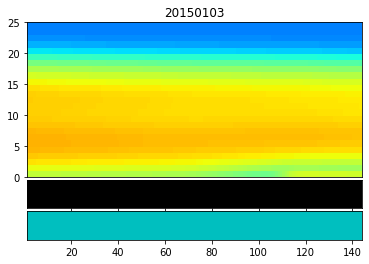

In [29]:
viz.evaluate_results()